In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay
from sklearn.metrics  import precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import  train_test_split,cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler

In [2]:
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler

In [4]:
# Load csv file
df = pd.read_csv('/content/aps_failure_training_set.csv', na_values="na")
df.shape

(30925, 171)

In [5]:
# Check unique values of target varaible
df['class'].value_counts()

,count
class,
neg,30001
pos,924


In [6]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

In [7]:
#Checking missing values percentage
missing =df.isna().sum()*100/df.shape[0]
missing

,0
class,0.000000
aa_000,0.000000
ab_000,77.215845
ac_000,5.988682
ad_000,25.529507
...,...
ee_007,1.018593
ee_008,1.018593
ee_009,1.018593
ef_000,4.831043


In [8]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing>70]
dropcols

,0
ab_000,77.215845
bn_000,72.475344
bo_000,76.261924
bp_000,78.573969
bq_000,80.303961
br_000,81.199677
cr_000,77.219078


In [9]:
df.drop(list(dropcols.index), axis=1, inplace=True)
df.shape

(30925, 164)

In [10]:
#Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 5.3844864641047385%


Visualization of unique values in Target variable

Positive: 924, Negative: 30001


<ipython-input-11-d7d4ba83b1b7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)


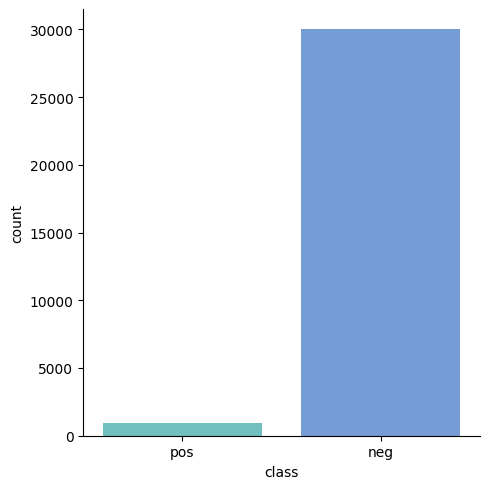

In [11]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

**Create Functions for model training and evaluation**

In [12]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [13]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification

    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [14]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    cost_list=[]
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)
        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')

        report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

    return report

 **Evaluate Model on Different experiments**

In [15]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

In [16]:
#Manually Encoding Target Variable
y= y.replace({'pos': 1, 'neg': 0})

<ipython-input-16-3d2a939f2065>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y= y.replace({'pos': 1, 'neg': 0})


In [17]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

In [18]:
#Finding the optimal n_neighbour value for KNN imputer
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.6900)
n_neighbors= 3 || accuracy (0.6887)
n_neighbors= 5 || accuracy (0.7200)
n_neighbors= 7 || accuracy (0.6460)
n_neighbors= 9 || accuracy (0.6707)


***We can observe n_neighbors=3 able to produce highest ***

***Pipeline for KNN imputer***

In [19]:
# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [20]:
X_knn =knn_pipeline.fit_transform(X)

In [21]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [23]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [24]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9918
- F1 score: 0.9920
- Precision: 0.9880
- Recall: 0.9961
- Roc Auc Score: 0.9917
- COST: 12740.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9815
- F1 score: 0.9820
- Precision: 0.9770
- Recall: 0.9871
- Roc Auc Score: 0.9814
- COST: 40920.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9850
- F1 score: 0.9850
- Precision: 0.9813
- Recall: 0.9886
- Roc Auc Score: 0.9850
- COST: 139480.
----------------------------------
Model performance for Test set
- Accuracy: 0.9819
- F1 score: 0.9823
- Precision: 0.9776
- Recall: 0.9871
- Roc Auc

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.5880
- F1 score: 0.6920
- Precision: 0.5507
- Recall: 0.9307
- Roc Auc Score: 0.5898
- COST: 1004590.
----------------------------------
Model performance for Test set
- Accuracy: 0.5937
- F1 score: 0.6995
- Precision: 0.5622
- Recall: 0.9255
- Roc Auc Score: 0.5864
- COST: 271530.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9802
- F1 score: 0.9803
- Precision: 0.9691
- Recall: 0.9918
- Roc Auc Score: 0.9802
- COST: 105030.
----------------------------------
Model performance for Test set
- Accuracy: 0.9742
- F1 score: 0.9751
- Precision: 0.9627
- Recall: 0.9879
- Roc Auc Score: 0.9739
- COST: 39340.


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9951
- F1 score: 0.9952
- Precision: 0.9932
- Recall

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9778
- F1 score: 0.9777
- Precision: 0.9758
- Recall: 0.9796
- Roc Auc Score: 0.9778
- COST: 248770.
----------------------------------
Model performance for Test set
- Accuracy: 0.9752
- F1 score: 0.9758
- Precision: 0.9741
- Recall: 0.9776
- Roc Auc Score: 0.9752
- COST: 70090.




In [25]:
#Report for KNN Imputed data
report_knn

,Model Name,Cost
5,XGBClassifier,8920
0,Random Forest,12740
4,K-Neighbors Classifier,39340
2,Gradient Boosting,40880
1,Decision Tree,40920
6,AdaBoost Classifier,70090
3,Logistic Regression,271530


 **Fitting the Final model and get reports**

In [27]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [30]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 1.0
Final XGBoost Classifier Accuracy Score (Test) : 0.9950660645592908


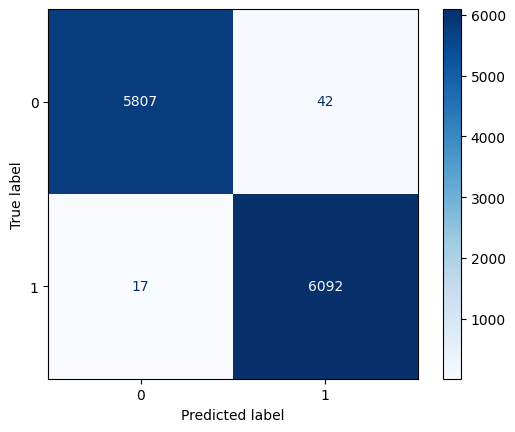

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

#plots Confusion matrix
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues', values_format='d')